In [34]:
# compare_rnn_lstm_gru.py
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

In [35]:
# ------------------------------------------------------
# 1. Data Loading & Preprocessing
# ------------------------------------------------------
def load_text_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for ch, i in char_to_idx.items()}
    data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)
    print(f"Loaded text with {len(text)} characters and {len(chars)} unique chars")
    return data, char_to_idx, idx_to_char

In [36]:
# ------------------------------------------------------
# 2. Model Architectures
# ------------------------------------------------------
class BaseRNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim, rnn_type="rnn"):
        super(BaseRNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(vocab_size, hidden_dim)
        if rnn_type == "rnn":
            self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        elif rnn_type == "lstm":
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        elif rnn_type == "gru":
            self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError("rnn_type must be 'rnn', 'lstm', or 'gru'")
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.rnn_type = rnn_type

    def forward(self, x, hidden):
        x = self.embed(x)
        out, hidden = self.rnn(x, hidden)
        logits = self.fc(out)
        return logits, hidden

    def init_hidden(self):
        if self.rnn_type == "lstm":
            return (torch.zeros(1, 1, self.hidden_dim),
                    torch.zeros(1, 1, self.hidden_dim))
        else:
            return torch.zeros(1, 1, self.hidden_dim)

In [37]:
# ------------------------------------------------------
# 3. Training Function
# ------------------------------------------------------
def train(model, data, seq_length, num_iters=5000, lr=0.05, epoch_size=100):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    pointer, curr_iter = 0, 0
    steps, losses, perplexities, accuracies = [], [], [], []
    hidden = model.init_hidden()

    while curr_iter < num_iters:
        if pointer + seq_length + 1 >= len(data):
            hidden = model.init_hidden()
            pointer = 0

        inputs = data[pointer:pointer+seq_length].unsqueeze(0)
        targets = data[pointer+1:pointer+seq_length+1].unsqueeze(0)

        optimizer.zero_grad()

        # Detach hidden to prevent exploding graph
        if isinstance(hidden, tuple):
            hidden = tuple(h.detach() for h in hidden)
        else:
            hidden = hidden.detach()

        logits, hidden = model(inputs, hidden)
        loss = criterion(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))

        loss.backward()
        optimizer.step()

        # Compute metrics every few steps
        if curr_iter % epoch_size == 0:
            with torch.no_grad():
                preds = logits.argmax(dim=-1)
                acc = (preds == targets).float().mean().item()
                ppl = math.exp(loss.item())

            steps.append(curr_iter)
            losses.append(loss.item())
            perplexities.append(ppl)
            accuracies.append(acc)
            print(f"[{model.rnn_type.upper()}] Step {curr_iter}/{num_iters} | Loss: {loss.item():.3f} | PPL: {ppl:.2f} | Acc: {acc*100:.1f}%")

        curr_iter += 1
        pointer += seq_length

    return steps, losses, perplexities, accuracies

In [38]:
# ------------------------------------------------------
# 4. Sampling (Text Generation)
# ------------------------------------------------------
def sample(model, start_char, char_to_idx, idx_to_char, sample_length=200):
    model.eval()
    hidden = model.init_hidden()
    input_idx = torch.tensor([[char_to_idx[start_char]]])
    generated = [start_char]

    for _ in range(sample_length):
        logits, hidden = model(input_idx, hidden)
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1).item()
        next_char = idx_to_char[next_idx]
        generated.append(next_char)
        input_idx = torch.tensor([[next_idx]])

    return ''.join(generated)

Loaded text with 5378667 characters and 107 unique chars

===== Training RNN Model =====
[RNN] Step 0/3000 | Loss: 4.766 | PPL: 117.49 | Acc: 0.0%
[RNN] Step 100/3000 | Loss: 3.459 | PPL: 31.80 | Acc: 12.0%
[RNN] Step 200/3000 | Loss: 2.432 | PPL: 11.38 | Acc: 66.0%
[RNN] Step 300/3000 | Loss: 3.734 | PPL: 41.85 | Acc: 26.0%
[RNN] Step 400/3000 | Loss: 3.804 | PPL: 44.90 | Acc: 12.0%
[RNN] Step 500/3000 | Loss: 4.345 | PPL: 77.09 | Acc: 24.0%
[RNN] Step 600/3000 | Loss: 4.892 | PPL: 133.19 | Acc: 16.0%
[RNN] Step 700/3000 | Loss: 3.528 | PPL: 34.07 | Acc: 20.0%
[RNN] Step 800/3000 | Loss: 3.034 | PPL: 20.77 | Acc: 14.0%
[RNN] Step 900/3000 | Loss: 3.807 | PPL: 45.04 | Acc: 32.0%
[RNN] Step 1000/3000 | Loss: 3.804 | PPL: 44.89 | Acc: 20.0%
[RNN] Step 1100/3000 | Loss: 4.458 | PPL: 86.33 | Acc: 14.0%
[RNN] Step 1200/3000 | Loss: 3.193 | PPL: 24.35 | Acc: 32.0%
[RNN] Step 1300/3000 | Loss: 4.781 | PPL: 119.18 | Acc: 16.0%
[RNN] Step 1400/3000 | Loss: 3.459 | PPL: 31.79 | Acc: 22.0%
[RNN] 

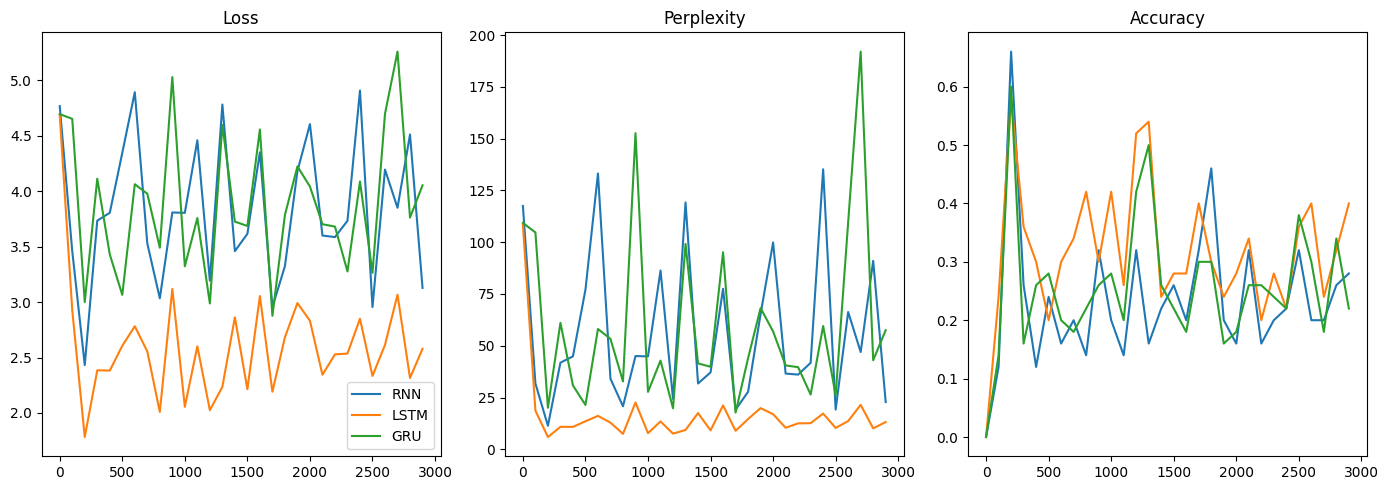

In [39]:
# ------------------------------------------------------
# 5. Run Experiment
# ------------------------------------------------------
if __name__ == "__main__":
    torch.manual_seed(42)
    data, c2i, i2c = load_text_data("rnn/datasets/shakespeare.txt")

    hidden_dim = 128
    seq_length = 50
    total_iters = 3000

    results = {}

    for rnn_type in ["rnn", "lstm", "gru"]:
        print(f"\n===== Training {rnn_type.upper()} Model =====")
        model = BaseRNNModel(len(c2i), hidden_dim, rnn_type)
        steps, losses, ppls, accs = train(model, data, seq_length, total_iters)
        results[rnn_type] = (steps, losses, ppls, accs, model)

    # --------------------------------------------------
    # 6. Plot Comparative Metrics
    # --------------------------------------------------
    plt.figure(figsize=(14, 5))

    # Loss curves
    plt.subplot(1, 3, 1)
    for name, (steps, losses, _, _, _) in results.items():
        plt.plot(steps, losses, label=name.upper())
    plt.title("Loss")
    plt.legend()

    # Perplexity curves
    plt.subplot(1, 3, 2)
    for name, (steps, _, ppls, _, _) in results.items():
        plt.plot(steps, ppls, label=name.upper())
    plt.title("Perplexity")

    # Accuracy curves
    plt.subplot(1, 3, 3)
    for name, (steps, _, _, accs, _) in results.items():
        plt.plot(steps, accs, label=name.upper())
    plt.title("Accuracy")

    plt.tight_layout()
    plt.show()

In [40]:
    # --------------------------------------------------
    # 7. Generate and Compare Sample Texts
    # --------------------------------------------------
    for name, (_, _, _, _, model) in results.items():
        print(f"\n----- Sample from {name.upper()} Model -----")
        print(sample(model, 'T', c2i, i2c, sample_length=300))
        print("------------------------------------------")


----- Sample from RNN Model -----
TRoseaseds to co spis theant ooun oantithanlos’J
PAROLLES.
PAROLLES.
PAROLLES.

PAROLLES.

PAROLLES.
PAROLLES.
PAROLLES.
PAROLLou.
PAROLLES.
PAROLLES.
PAROLLES.
PAROLLES.
PAROLLES.
PAROLLES.
PAROLLES.
PAROLLES.
PAROLLES.
PAROLLES.
PAROLL
PAROLLES.
PAROLLES.
PAROLLES.


PAROLLES.
PAROLLES.
PAROLLES.
P
------------------------------------------

----- Sample from LSTM Model -----
TRAM.
PAROLES.
LExAbelen willof lor angaris.

PAROLES!

LAFEW.
LExpr w-Ast!

LAFEW.
PAROr’t sioung. and sio.

PAROLES.

LAFESbld!

Ante momststeromour spasto maA fus ca, mak!
Yourmost mpean A.

PAROLES.

LAROLLESct wistat whoust!

LAFEW.
PAROLES.
PAROLLES.

LAFEW.t_?
RAt hay to romt hount.
Yor? mourp
------------------------------------------

----- Sample from GRU Model -----
TEx. anane I comy mio my nand whast ay cyould and my lov’s eunteo manct astiod?

















































LAFEW.
Ya, seleas ateomes is ant atid?



AFFMy to lasty houn.
Yo Ross and 